## Flow Classification Task 

For this task we perform classification first on packet level and the on host level for scenario 10 in the CTU-13 dataset.

In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE, BorderlineSMOTE 
import seaborn as sns
import warnings
from helper_functions.classification import *
warnings.filterwarnings("ignore")

Keep the number of infected and normal ips given by the scenario.

In [2]:
infected_hosts = ['147.32.84.165','147.32.84.191','147.32.84.192','147.32.84.193','147.32.84.204',
                  '147.32.84.205','147.32.84.206', '147.32.84.207','147.32.84.208','147.32.84.209']

normal_hosts = ['147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36, 147.32.80.9', '147.32.87.11']


Load the preprocessed data from the task 4.

In [3]:
data = pd.read_csv('./capture20110818.pcap.netflow.labeled.remastered')
data[['Src_IP_Addr', 'Src_Port']] = data['Src_IP_Addr:Port'].str.split(':', n=1, expand=True)
data[['Dst_IP_Addr', 'Dst_Port']] = data['Dst_IP_Addr:Port'].str.split(':', n=1, expand=True)

data['Datetime'] = data['#Date_flow'].str.cat(data['start'], sep=' ')
#data['Datetime'] = pd.to_datetime(data['Datetime'], infer_datetime_format=True)

data.drop(labels=['#Date_flow', 'start', 'Src_IP_Addr:Port', 'Dst_IP_Addr:Port'], axis=1, inplace=True)
data.head()

,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Label,Src_IP_Addr,Src_Port,Dst_IP_Addr,Dst_Port,Datetime
0,0.002,TCP,FRPA_,0,4,321,1,Background,147.32.86.166,33426,212.24.150.110,25443,2011-08-18 10:19:13.328
1,4.995,UDP,INT,0,617,40095,1,Background,82.39.2.249,41915,147.32.84.59,43087,2011-08-18 10:19:13.328
2,4.996,UDP,INT,0,1290,1909200,1,Background,147.32.84.59,43087,82.39.2.249,41915,2011-08-18 10:19:13.329
3,0.000,TCP,A_,0,1,66,1,Background,147.32.86.166,42020,147.32.192.34,993,2011-08-18 10:19:13.330
4,0.000,TCP,FPA_,0,2,169,1,Background,212.24.150.110,25443,147.32.86.166,33426,2011-08-18 10:19:13.330


In [4]:
# remove background 
data_nobground = data[ data['Label'] != 'Background']
data_nobground.shape

(645358, 13)

In [5]:
data_nobground.head()

,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Label,Src_IP_Addr,Src_Port,Dst_IP_Addr,Dst_Port,Datetime
20,4.985,TCP,PA_,0,91,86277,1,LEGITIMATE,147.32.80.13,80,147.32.85.88,56949,2011-08-18 10:19:13.347
51,0.000,TCP,A_,0,1,66,1,LEGITIMATE,147.32.86.110,48102,74.125.232.214,443,2011-08-18 10:19:13.392
57,4.921,TCP,A_,0,49,3234,1,LEGITIMATE,147.32.85.88,56949,147.32.80.13,80,2011-08-18 10:19:13.411
73,4.742,TCP,A_,0,118,7080,1,LEGITIMATE,147.32.84.59,2768,74.125.108.208,80,2011-08-18 10:19:13.460
75,0.000,TCP,A_,0,1,60,1,LEGITIMATE,147.32.84.59,56058,74.125.232.215,443,2011-08-18 10:19:13.486


In [6]:
# We keep a copy of the data set to used for the host level.
new_nobground = data_nobground.copy()

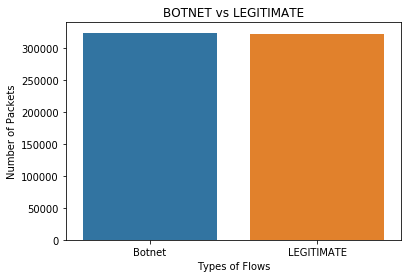

Number of Botnet:  323441
Number of Legitimate:  321917
Ratio:  1.0047341395452865


In [7]:
# Check for imbalance
ax = data_nobground['Label'].value_counts()
plt.title('BOTNET vs LEGITIMATE')
sns.barplot(x=ax.index, y= ax)  
plt.xlabel('Types of Flows')
plt.ylabel('Number of Packets')
plt.show()

val_1 = len(data_nobground[data_nobground['Label'] == 'Botnet'])
val_2 = len(data_nobground[data_nobground['Label'] == 'LEGITIMATE'])
print("Number of Botnet: ", val_1)
print("Number of Legitimate: ", val_2)
print("Ratio: ", val_1/val_2)

In [8]:
# Produce labels 
label_mapping={}
label_mapping['Label'] = {'LEGITIMATE': 0, 'Botnet' : 1}
data_nobground.replace({'Label' : label_mapping['Label']}, inplace=True)

# Keep the labels 
labels= data_nobground['Label'].values


### Convesion of categorical data to numeric

Each column of type "object" is converted, based on an enumeration of its unique values. We did not use one-hot encoding for the conversion, as this would lead to unnecessary creation of extra columns, thus to the increase of the dimensionality of feature space.

In [9]:
char_cols =  data_nobground.dtypes.pipe(lambda x: x[x == 'object']).index
for c in char_cols:
    data_nobground[c], label_mapping[c] = pd.factorize( data_nobground[c])

In [10]:
# Drop the labels
X = data_nobground.drop(['Label','Datetime'], axis = 1).values
print("Dataset shape: ", X.shape)

Dataset shape:  (645358, 11)


### Classification on packet level
We used the following classifiers:
- Naive Bayes
- Random Forrest 
- Logistic Reggresion

In [11]:
# 10-Fold stratified cross validation with shuffling of the dataset before extracting the stratified splits,
# used for estimating performance
num_splits = 10
cv = StratifiedKFold(n_splits = num_splits, shuffle = True)

In [12]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
nb_mean_tpr, nb_std_tpr, nb_mean_auc, nb_std_auc, mean_F1, std_F1, cm =roc_analysis(X, labels, clf, cv, False, False, False)

print(cm)
acc, prec, rec, F1 = performance_metrics(cm)
print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

[[313582   4472]
 [  9859 317445]]
Accuracy: 0.978
Precision: 0.986
Recall: 0.970
F1_score: 0.978


In [13]:
from  sklearn.linear_model import LogisticRegression as LR

clf = LR(C = 1, solver = 'lbfgs', multi_class = 'ovr', n_jobs=-1)
nb_mean_tpr, nb_std_tpr, nb_mean_auc, nb_std_auc, mean_F1, std_F1, cm =roc_analysis(X, labels, clf, cv, False, False, False)

print(cm)
acc, prec, rec, F1 = performance_metrics(cm)
print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

[[313876  58370]
 [  9565 263547]]
Accuracy: 0.895
Precision: 0.843
Recall: 0.970
F1_score: 0.902


In [14]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)
clf = LR(C = 1, solver = 'lbfgs', multi_class = 'ovr', n_jobs=-1)

nb_mean_tpr, nb_std_tpr, nb_mean_auc, nb_std_auc, mean_F1, std_F1, cm =roc_analysis(X, labels, clf, cv, False, False, False)

print(cm)
acc, prec, rec, F1 = performance_metrics(cm)
print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

[[313936  59834]
 [  9505 262083]]
Accuracy: 0.893
Precision: 0.840
Recall: 0.971
F1_score: 0.901


### Classification on Host Level 
write more

In [22]:
''''
Group by Src ip 
constuct new features: 
the amount dst ips per unique src. 
the amount of src ports per unique src. 
the amount of dst ports per unique src.
'''''

data_perhost = data_nobground.groupby(by='Src_IP_Addr').agg({'Durat':'sum', 'Prot':'sum', 'Flags':'sum', 'Tos':'sum', 'Packets':'sum', 'Bytes':'sum', 'Flows':'sum', 'Label':'max'})
data_perhost['Dst_IPs'] = data_nobground.groupby('Src_IP_Addr')['Dst_IP_Addr'].nunique()
data_perhost['Src_Ports'] = data_nobground.groupby('Src_IP_Addr')['Src_Port'].nunique()
data_perhost['Dst_Ports'] = data_nobground.groupby('Src_IP_Addr')['Dst_Port'].nunique()

hosts = data_perhost.index


In [23]:
data_perhost.head()

,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Label,Dst_IPs,Src_Ports,Dst_Ports
Src_IP_Addr,,,,,,,,,,,
0,36118.226,0,67083,0,3057764,4113893358,36949,0,53,16,6104
1,2433.508,0,3672,0,10667,4287341,2921,0,43,325,2
2,14737.020,0,76580,0,233738,59270611,11801,0,4,4640,2
3,45904.780,194,287231,0,710691,312132150,90560,0,208,14179,11
4,6585.936,3452,36352,0,50649,10206525,10910,0,155,2856,22


In [24]:
labels = data_perhost['Label'].values
data_perhost.drop(labels='Label', axis=1, inplace=True)
X = data_perhost.values

print(X.shape)
print("Imbalance ratio: ", np.sum(labels)/np.sum(labels==0))

(522, 10)
Imbalance ratio:  0.14725274725274726


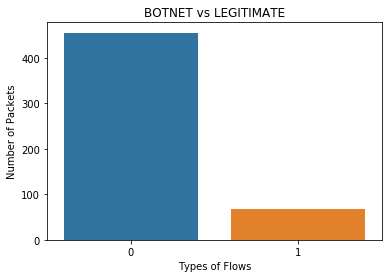

Number of infected: 67
Number of normal: 455


In [38]:
ax, counts = np.unique(labels, return_counts=True)
plt.title('BOTNET vs LEGITIMATE')
sns.barplot(x= ax, y=counts)  
plt.xlabel('Types of Flows')
plt.ylabel('Number of Packets')
plt.show()

print('Number of infected:', counts[1])
print('Number of normal:', counts[0])

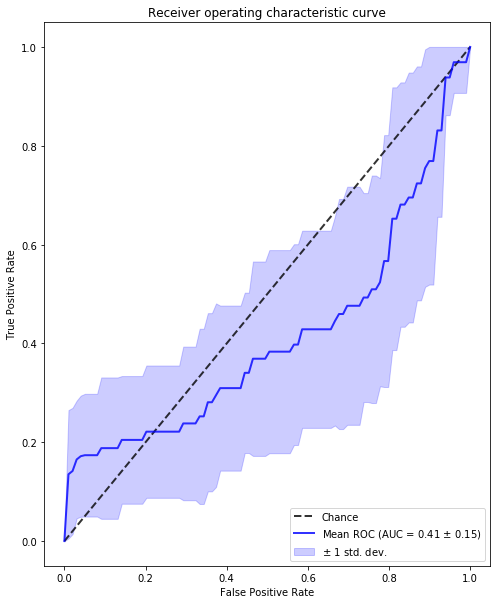

[[ 11   5]
 [ 56 450]]
Accuracy: 0.883
Precision: 0.688
Recall: 0.164
F1_score: 0.265


In [60]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
nb_mean_tpr, nb_std_tpr, nb_mean_auc, nb_std_auc, mean_F1, std_F1, cm =roc_analysis(X, labels, clf, cv, False, True, False)

print(cm)
acc, prec, rec, F1 = performance_metrics(cm)
print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

In [46]:
# Use cross-validation to determine the best overasmpling ratio
ratios = np.array([ 0.2, 0.5, 0.8, 1])
num_neighbours = np.array([1,2,3,5])

m_auc_cv = np.zeros((len(ratios), len(num_neighbours)))
std_auc_cv = np.zeros_like(m_auc_cv)
m_F1_cv = np.zeros_like(m_auc_cv)
std_F1_cv = np.zeros_like(m_auc_cv)


i = 0
for r in ratios: 
    j = 0
    for n in num_neighbours:
        sm = SMOTE(sampling_strategy=r, k_neighbors=n)
        _, _, m_auc_cv[i,j], std_auc_cv[i,j], m_F1_cv[i,j], std_F1_cv[i,j],_ = roc_analysis(X, labels, clf, cv, 
                                                                                False, False, False, sm)
        j = j+1
    i = i+1

# Output the mean metrics extracted; rows correspond to over-sampling ratio and columns to number of neighbours
print("Mean AUC:\n", m_auc_cv)
# print("std AUC:\n", std_auc_cv)
print("Mean F1:\n", m_F1_cv)
# print("std F1:\n", std_F1_cv)

Mean AUC:
 [[0.47104377 0.45701605 0.4817023  0.4508986 ]
 [0.46877432 0.45590319 0.45269579 0.4553617 ]
 [0.46863658 0.45820907 0.4673182  0.47818371]
 [0.45601907 0.4552123  0.45538502 0.4567996 ]]
Mean F1:
 [[0.23106061 0.22388889 0.24277778 0.22634921]
 [0.2402381  0.24968254 0.24166667 0.2465873 ]
 [0.25025253 0.24666667 0.23787879 0.26096681]
 [0.24166667 0.2602381  0.2452381  0.25825397]]


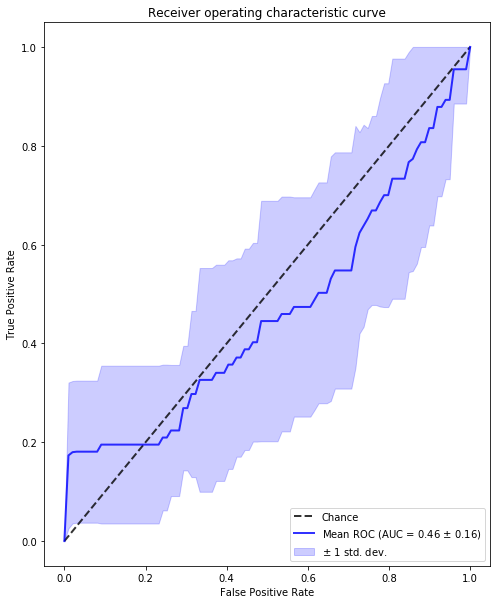

[[ 11   4]
 [ 56 451]]
Accuracy: 0.885
Precision: 0.733
Recall: 0.164
F1_score: 0.268


In [65]:
sm = SMOTE(sampling_strategy=0.8, k_neighbors=5)

clf = GaussianNB()
nb_mean_tpr, nb_std_tpr, nb_mean_auc, nb_std_auc, mean_F1, std_F1, cm =roc_analysis(X, labels, clf, cv, False, True, False,sm)

print(cm)
acc, prec, rec, F1 = performance_metrics(cm)
print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)


In [28]:
from  sklearn.linear_model import LogisticRegression as LR

clf = LR(C = 1, solver = 'lbfgs', multi_class = 'ovr', n_jobs=-1)
nb_mean_tpr, nb_std_tpr, nb_mean_auc, nb_std_auc, mean_F1, std_F1, cm =roc_analysis(X, labels, clf, cv, False, False, False)

print(cm)
acc, prec, rec, F1 = performance_metrics(cm)
print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

[[ 34  24]
 [ 33 431]]
Accuracy: 0.891
Precision: 0.586
Recall: 0.507
F1_score: 0.544


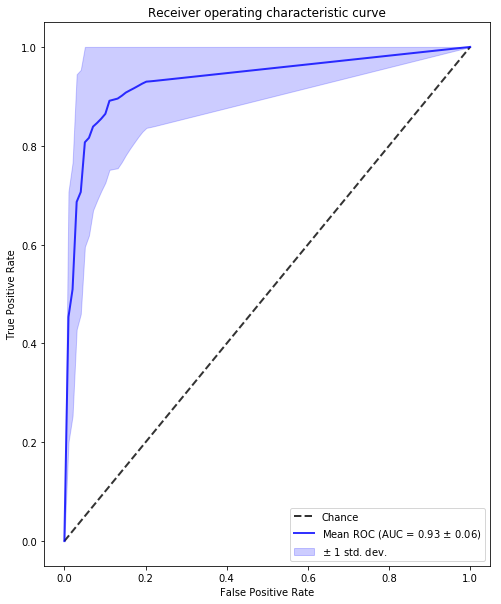

[[ 45  11]
 [ 22 444]]
Accuracy: 0.937
Precision: 0.804
Recall: 0.672
F1_score: 0.732


In [66]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)
nb_mean_tpr, nb_std_tpr, nb_mean_auc, nb_std_auc, mean_F1, std_F1, cm =roc_analysis(X, labels, clf, cv, False, True, False)

print(cm)
acc, prec, rec, F1 = performance_metrics(cm)
print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)